# Code Deep Dive

### Amazon Lex Bot and Lambda

#### Data Validation

##### Do you need a recommendation?

```py
#Get recommendations
    if recommend is not None and crypto is None :
        if recommend.lower() == 'yes':
            # results = getRecommendation()
            message = "As someone who has come from the Future, my recommendations are as follows:\n" + recommendations
            
            return build_validation_result(
                True,
                "crypto",
                message,
            )
        elif recommend.lower() == 'no':
            # results = getRecommendation()
            message = "Alas! I knew the future but you missed out. Please select the coin you want to buy."
        
            return build_validation_result(
                True,
                "crypto",
                message,
            )
 ```

##### Check whether user has enough cash in the account to buy the coin or not

```py

    # Get max coins user can buy of the selected cryptocurrency
    if recommend is not None and crypto is not None and coins is None:
        coinpair = getCoinAbbreviation(crypto)
        max_vol = calculateMaxCoinToBuy(coinpair)
        min_vol = minimumCoinVolume(crypto)
        message = "Your balance in the exchange is: " + balance + ". Based on available cash balance in your exchange, maximum " + crypto + " you can buy is " + str(max_vol) + ". Please enter the amount of coins to buy keeping in mind the maximum volume."
        
        if max_vol < min_vol:
            return build_validation_result(
                False,
                "crypto",
                "You dont have sufficient balance to buy minimum volume required (" + str(min_vol) + ") of " + crypto + ". Please choose another coin or top up your balance in the exchange.", 
            )
        
        return build_validation_result(
            True,
            "coins",
            message,
        )
```

##### Check number of coins provided is between min and max range

```py
    # Get max coins user can buy of the selected cryptocurrency
    if recommend is not None and crypto is not None and coins is None:
        coinpair = getCoinAbbreviation(crypto)
        max_vol = calculateMaxCoinToBuy(coinpair)
        min_vol = minimumCoinVolume(crypto)
        message = "Your balance in the exchange is: " + balance + ". Based on available cash balance in your exchange, maximum " + crypto + " you can buy is " + str(max_vol) + ". Please enter the amount of coins to buy keeping in mind the maximum volume."
        
        if max_vol < min_vol:
            return build_validation_result(
                False,
                "crypto",
                "You dont have sufficient balance to buy minimum volume required (" + str(min_vol) + ") of " + crypto + ". Please choose another coin or top up your balance in the exchange.", 
            )
        
        return build_validation_result(
            True,
            "coins",
            message,
        )

```

#### Getting Recommendations
```py
def getPredictedSignals():
    bucket = 'tradinator'
    currencyList = ['ADA-AUD_predictions','BCH-AUD_predictions','ETH-AUD_predictions', 'LTC-AUD_predictions', 'XLM-AUD_predictions', 'XRP-AUD_predictions', 'BTC-AUD_predictions'] #List of name of files that are uploaded to S3 without extension
    results = ""
    # For loop to traverse through the list for get latest predictions ans return a concatenated message back to the bot
    for curr in currencyList:
        key = 'predictions/' + curr + '.csv'
        s3_resource = boto3.resource('s3')
        s3_object = s3_resource.Object(bucket, key) # Create S3 objecct
        data = s3_object.get()['Body'].read().decode('utf-8').splitlines() #Fetch the data
        lines = csv.reader(data)
        headers = next(lines)
        rows=[]
        for line in lines:
            rows.append(line)
        total_rows = len(rows)
        # Getting the last row which will be latest prediction. Predictions are updated every hour so the latest predictions will be the current hour.
        if rows[total_rows-1][2] == '1':
            results = results + '\n' + rows[total_rows-1][1] + ": Buy or Hold,"
        elif rows[total_rows-1][2] == '0':
            results = results + '\n' + rows[total_rows-1][1] + ": Don't Buy or Sell,"
    return results

```

#### Executing Trade

```py

    def executeTrade(crypto, coins):
        coinpair = getCoinAbbreviation(crypto)
        coins = parse_float(coins)
        result = kraken.placeOrder("market","buy", coinpair, 0, coins)
        balance = getBalance()
        return balance
        
    def placeOrder(ordertype, type, pair, price, volume=0):
        nonce = int(1000*time.time())
        postdata = {}
        postdata['nonce'] = str(nonce)
        postdata['ordertype'] = ordertype.lower()
        postdata['type'] = type.lower()
        postdata['volume'] = volume
        postdata['pair'] = pair.upper()
        postdata['price'] = price
        urlpath = '/0/private/AddOrder'
        headers = getHeaders(urlpath, postdata)
        url = endpoint + urlpath
        result = executePostRequest(url, headers, postdata, 'result')
        return result

```

### Exchange Integration

#### Kraken Integration

```py
    endpoint = "https://api.kraken.com"
    
    def executePostRequest(url, headers, params, key):
    try:
        response = requests.post(url, headers=headers, data=params)
        result = response.json() #json.loads(response.text)
        if len(result['error']) == 0:
            return result[key]
        else :#result['status'].lower() == 'error':
            raise requests.RequestException(result["error"])
    except requests.RequestException as ex:
        return "error:" + str(ex)
    except Exception as ex:
        return "error:" + str(ex)
        
    def placeOrder(ordertype, type, pair, price=0, volume=0):
        nonce = int(1000*time.time())
        postdata = {}
        postdata['nonce'] = str(nonce)
        postdata['ordertype'] = ordertype.lower()
        postdata['type'] = type.lower()
        postdata['volume'] = volume
        postdata['pair'] = pair.upper()
        postdata['price'] = price
        urlpath = '/0/private/AddOrder'
        headers = getHeaders(urlpath, postdata)
        url = endpoint + urlpath
        result = executePostRequest(url, headers, postdata, 'result')
        return result
```

#### CoinSpot Integration
```py
    private_endpoint = "https://www.coinspot.com.au/api"
    public_endpoint = "https://www.coinspot.com.au/pubapi"
    
    def placeBuyOrder(coin, amount):
        rate = getLatestPrice(coin.lower())['bid']
        nonce = int(time()*1000000)
        postdata = {}
        postdata['cointype'] = coin.upper()
        postdata['amount'] = amount
        postdata['rate'] = rate
        postdata['nonce'] = nonce
        params = json.dumps(postdata, separators=(',', ':'))
        headers = getHeaders(params)
        url = private_endpoint + "/my/buy"
        result = executePostRequest(url, headers, params, 'status')
        return result
    
    def placeSellOrder(coin, amount):
        rate = getLatestPrice(coin.lower())['ask']
        nonce = int(time()*1000000)
        postdata = {}
        postdata['cointype'] = coin.upper()
        postdata['amount'] = amount
        postdata['rate'] = rate
        postdata['nonce'] = nonce
        params = json.dumps(postdata, separators=(',', ':'))
        headers = getHeaders(params)
        url = private_endpoint + "/my/sell"
        result = executePostRequest(url, headers, params, 'status')
        return result
```

### Predictions and Trading Script
```py
schedule.every().hour.at("01:00").do(predictions, file=joblib_file)

async def getPredictionsPerCoin(curr, since, pipeline):
    csv_filename = curr.replace('/','-') + '_predictions.csv'
    csv_path = 'Resources/' + csv_filename
    df = kr.getOHLC_CCXT(curr, since)
    df_tech_indicators = calculateIndicators(curr, df)
    X_data = df_tech_indicators.loc[:, indicators_list].reset_index(drop=True)
    y_data = df_tech_indicators.loc[:, ['Currency']].copy()
    y_data['Predictions'] = pipeline.predict(X_data)
    await executeTrade(curr,y_data['Predictions'][-1])
    y_data.to_csv(csv_path)
    result = uploadFileToS3(csv_path, 'predictions/' + csv_filename)
    return curr + " predictons generated and uploaded." if result else curr + " predictons generated but not uploaded."
```

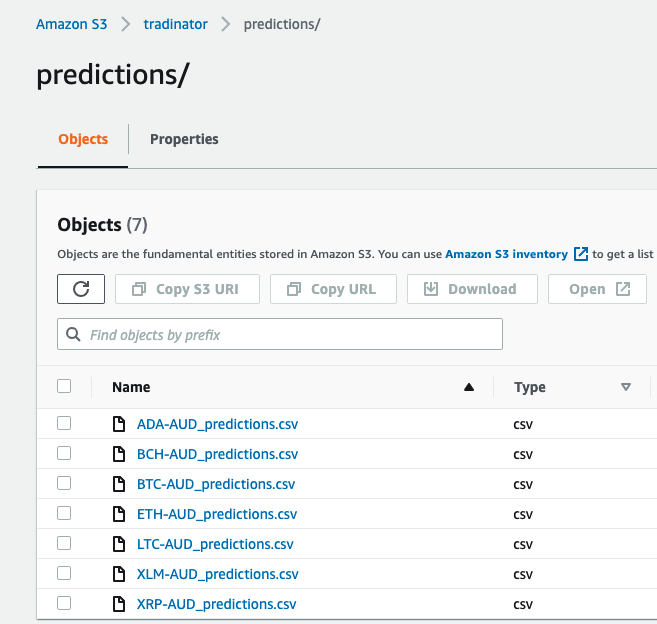

![Logs](Log.png)